In [3]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from pandas.api.types import is_numeric_dtype

In [4]:
hdf=pd.HDFStore('Train.h5',mode='r')
hdf.items()

<generator object HDFStore.items at 0x0000026B57B36A20>

In [5]:
hdf.keys()
df1=hdf.get('/df').fillna(0)

In [6]:
df1['Word Count'] = df1['Tweet content'].str.split().str.len()

Columnlist = [] 

D:\ProgramsInstalled\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
D:\ProgramsInstalled\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
D:\ProgramsInstalled\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
D:\ProgramsInstalled\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
D:\ProgramsInstalled\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
D:\ProgramsInstalled\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
D:\ProgramsInstalled\Anaconda3\lib\site-packages\ipykernel_launc

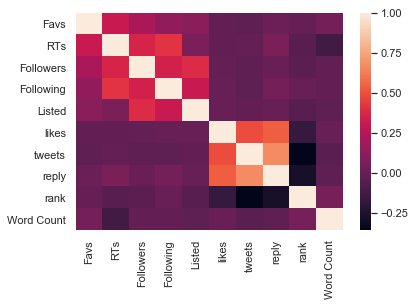

In [7]:
df2=df1
for c in df1.columns:
    if c!='Tweet Id' and  df2.dtypes[c]== 'float64' :
        q = df2[c].quantile(0.99)
        df2=df2[df1[c] < q]
        Columnlist.append(c)

corr = pd.DataFrame()
for a in Columnlist:
    for b in Columnlist:
        corr.loc[a, b] = df2.corr().loc[a, b]
ax = sns.heatmap(corr)

colors = plt.cm.rainbow(np.linspace(0, 1, len(Columnlist)))

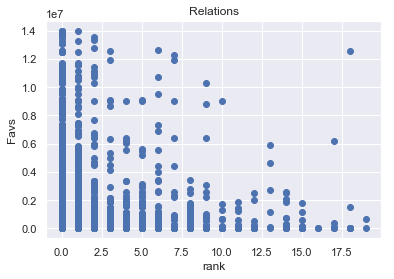

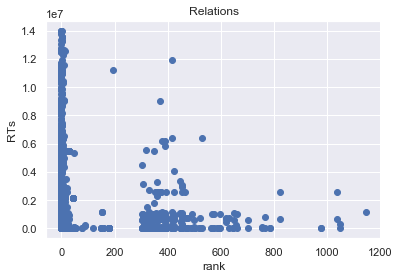

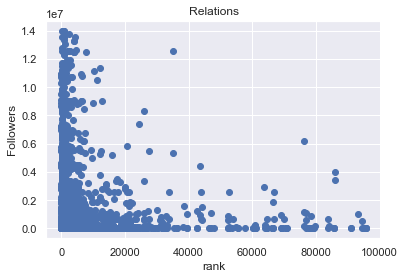

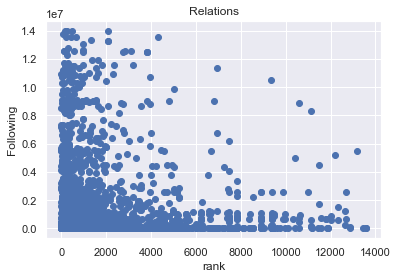

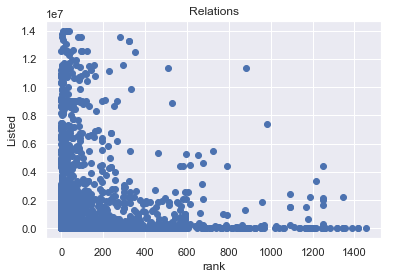

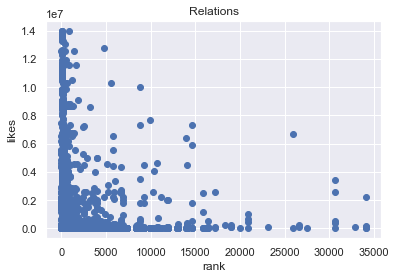

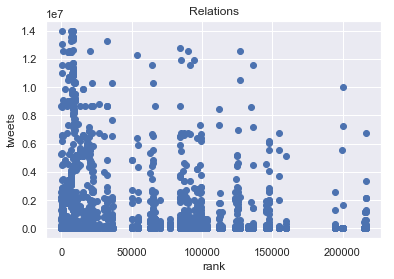

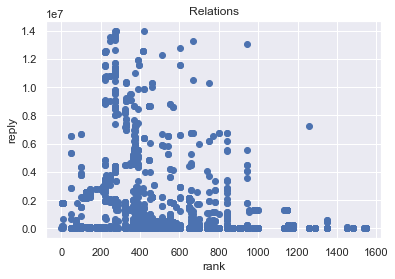

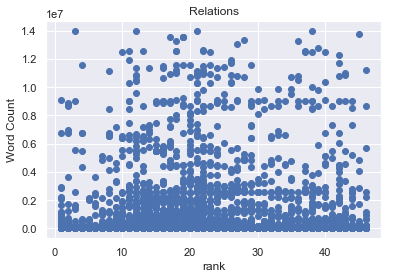

In [8]:
for c in Columnlist:
    if c!="rank":
        fig = plt.figure()
        plt.scatter(df2[c],df2["rank"])
        plt.xlabel('rank')
        plt.ylabel(c)
        plt.title('Relations')
        plt.show()

In [9]:
#remove outliers
low = .03
high = .91
quant_df = df2.quantile([low, high])
for col in Columnlist:
        if is_numeric_dtype(df2[col]):
            df2 = df2[(df2[col] > quant_df.loc[low, col]) & (df2[col] < quant_df.loc[high, col])]
 

In [10]:
 #it is our target
Columnlist.remove('rank')

#remove Highly correlated features
Columnlist.remove('reply')

In [11]:
#Seperate Data for test,validation,train
input_train,input_test_validation=sklearn.model_selection.train_test_split(df2,test_size=0.6,random_state=100,shuffle=True)
input_validation,input_test=sklearn.model_selection.train_test_split(input_test_validation,test_size=0.5,random_state=100,shuffle=True)
min_max_scaler = preprocessing.MinMaxScaler()
 

In [12]:
#linear regression
y=  (input_train['rank']-min(input_train['rank'])) /( max(input_train['rank'])-min(input_train['rank']))
yv= (input_validation['rank']-min(input_validation['rank'])) /( max(input_validation['rank'])-min(input_validation['rank'])) 
yt= (input_test['rank']-min(input_test['rank'])) /( max(input_test['rank'])-min(input_test['rank'])) 
least_error=np.finfo(np.float64).max
featurewithLeastSimple=""

In [13]:
#Scale all data between 0 and 1
df3=input_train[Columnlist]
tempcolumnnames=df3.columns
x_scaled=min_max_scaler.fit_transform(df3)
df3 = pd.DataFrame(x_scaled)
df3.columns=tempcolumnnames


ANOVA results
            df    sum_sq   mean_sq         F    PR(>F)
x          1.0  0.087620  0.087620  0.734769  0.394309
Residual  69.0  8.228114  0.119248       NaN       NaN


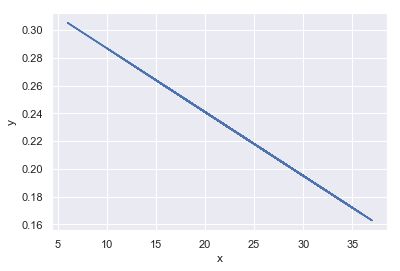

Best Feature was: likes


In [14]:
#Simple regression
for col in Columnlist:
    x=input_train[col]
    Linearmodel = ols("y ~ x", x).fit()
    offset, coef = Linearmodel._results.params
    anova_results = anova_lm(Linearmodel)
    if(least_error> anova_results['mean_sq'][1]):
        least_error=anova_results['mean_sq'][1]
        featurewithLeastSimple=col
print('\nANOVA results')
print(anova_results)
plt.plot(x, x*coef + offset)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print ('Best Feature was: '+ featurewithLeastSimple )



In [15]:
#multiple feature regression 
multipleReg = LinearRegression()
multipleReg.fit(df3, y) 
print('Weights are : ')
print (multipleReg.coef_)
pridiction=multipleReg.predict(input_validation[Columnlist]);
mea= sum(abs(yv-pridiction))/len(yv)
print("Mea for multipleReg:",mea)

Weights are : 
[ 0.0221623  -0.05207481 -0.19675975  0.15626605  0.26464201 -0.36344048
 -0.1690063  -0.01563525]
Mea for multipleReg: 12370.926374427912


In [16]:
#Ridge regression
clfRidge = Ridge(alpha=0.01)
clfRidge.fit(df3, y) 
pridiction=clfRidge.predict(input_validation[Columnlist]);
mea= sum(abs(yv-pridiction))/len(yv)
print("Mea for Ridge:",mea)
RSS = (abs(yv - pridiction) ** 2).sum()
print("RSS for Ridge:",RSS)
print(clfRidge.score(input_validation[Columnlist],yv, sample_weight=None))

Mea for Ridge: 12398.392663787126
RSS for Ridge: 11758785273.54724
-2209912715.0201554


In [17]:
#Lasso 
reglasso = Lasso(alpha =0.001)
reglasso.fit(df3, y) 
print(reglasso)
pridiction=reglasso.predict(input_validation[Columnlist]);
mea= sum(abs(yv-pridiction))/len(yv)
print("Mea for Lasso:",mea)#Lasso 
reglasso = Lasso(alpha =0.001)
reglasso.fit(df3, y) 
print(reglasso)
pridiction=reglasso.predict(input_validation[Columnlist]);
mea= sum(abs(yv-pridiction))/len(yv)
print("Mea for Lasso:",mea)


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Mea for Lasso: 12500.33729199392
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Mea for Lasso: 12500.33729199392


In [18]:
#lasso feature seleaction
featureSelection = SelectFromModel(reglasso)
featureSelection.fit(df3, y) 
selectedFeatures = featureSelection.transform(df3)
collistNice=[]
collistNiceindex=df3.columns[featureSelection.get_support()]
for col in collistNiceindex:
            print(col)
            collistNice.append(col)
dfLasso=df3[collistNiceindex]

Favs
Followers
Following
Listed
likes
tweets
Word Count


In [19]:
#Ridge regression after lasso
clfRidgeAfterlasso = Ridge(alpha=0.01)
clfRidgeAfterlasso.fit(dfLasso, y) 
pridiction=clfRidgeAfterlasso.predict(input_validation[collistNice]);
mea= sum(abs(yv-pridiction))/len(yv)
print("Mea for Ridge after Lasso:",mea)
RSS = (abs(yv - pridiction) ** 2).sum()
print("RSS for Ridge  after Lasso:",RSS)
print(clfRidgeAfterlasso.score(input_validation[collistNice],yv, sample_weight=None))

Mea for Ridge after Lasso: 12576.64482150145
RSS for Ridge  after Lasso: 12101065619.466623
-2274239911.3499207


In [20]:
""" Test Section """
pridiction=multipleReg.predict(input_test[Columnlist]);
mea= sum(abs(yt-pridiction))/len(yt)
print("Mea for multipleReg test:",mea)

pridiction=clfRidge.predict(input_test[Columnlist]);
mea= sum(abs(yt-pridiction))/len(yt)
print("Mea for Ridge test:",mea)

pridiction=reglasso.predict(input_test[Columnlist]);
mea= sum(abs(yt-pridiction))/len(yt)
print("Mea for Lasso test:",mea)

pridiction=clfRidgeAfterlasso.predict(input_validation[collistNice]);
mea= sum(abs(yv-pridiction))/len(yv)
print("Mea for Ridge after Lasso:",mea)

Mea for multipleReg test: 12482.13213080699
Mea for Ridge test: 12507.81083368276
Mea for Lasso test: 12563.095481704373
Mea for Ridge after Lasso: 12576.64482150145


In [21]:
"""StepWise Section"""
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(list(y), sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(list(y), sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included



result = stepwise_selection(df3,y)
print('resulting features from stepwise algorithms:')
print(result)

Add  likes                          with p-value 0.00511194
resulting features from stepwise algorithms:
['likes']


D:\ProgramsInstalled\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


In [22]:
# Non parametric regression 
#Nearest Neighbors with 5 neighbor
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(df3, y)
#K nearest neighbors with 5 neighbor
kneigh = KNeighborsRegressor(n_neighbors=5)
kneigh.fit(df3, y)
distances, indices = kneigh.kneighbors(df3)
print("Estimated value for selected features:",
      kneigh.predict(input_validation[Columnlist]))

Estimated value for selected features: [0.00452998 0.19415478 0.13057353 0.13057353 0.01073808 0.38146165
 0.13057353 0.13057353 0.13057353 0.13057353 0.38652472 0.13057353
 0.38652472 0.19415478 0.13057353 0.13057353 0.13057353 0.13057353
 0.19415478 0.19415478 0.13057353 0.13057353 0.19415478 0.13057353
 0.19415478 0.38264315 0.13057353 0.38652472 0.13057353 0.00278452
 0.13057353 0.13057353 0.13057353 0.38146165 0.00466316 0.32080905
 0.13057353 0.00278452 0.13057353 0.19415478 0.13057353 0.19415478
 0.13057353 0.19415478 0.13057353 0.13057353 0.38146165 0.19415478
 0.13057353 0.19415478 0.13057353 0.13057353 0.19415478]


In [23]:
#Kernel destiny
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(df3)
kdescore=kde.score(df3,yv)
print("Kernel score:",kdescore)


Kernel score: -413.6753771354009


In [24]:
##Write prediction to file
dfl=df1[Columnlist].fillna(0)
pridiction=multipleReg.predict(dfl)
Columnlist.append('Tweet Id')
Columnlist.append('User Name')
df1=df1[Columnlist]
df1['result']=pridiction
pt = pd.DataFrame(df1)
pt.to_csv('./target.csv',encoding='utf-8')